## Predicting Heart Failure 


Heart disease is a leading cause of death among adults.  According to the World Health Organization, nearly 18 million people die each year from heart disease (WHO, 2022).  Heart failure is a common result of heart disease and is identified by a variety of factors influencing the heart’s ability to properly function.  

- age: age of the patient (years)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L) 

These are some of the clinical features to consider when predicting if a patient will die from heart failure.  A data set compiled by the University of California, Irvine showcases these factors in patients experiencing heart failure and the outcome of survival.  

**Question :**
Predicting if a patient will die of heart failure based on the clinical features mentioned above. 

In [1]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0  

## Reading the dataset

In [2]:
heart_failure <- read_csv("https://raw.githubusercontent.com/Parcode19/Group_project/main/heart_failure_clinical_records_dataset.csv")
heart_failure

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,0,2060,1,60,0,742000,0.8,138,0,0,278,0
45,0,2413,0,38,0,140000,1.4,140,1,1,280,0
50,0,196,0,45,0,395000,1.6,136,1,1,285,0


## Cleaning and wrangling the data


### Selecting the columns to be used for the data analysis

We clean the data and only select the columns which are needed for our analysis and answering our question. We also modify the `DEATH_EVENT` column and change the `1` to `Fatal` and `0` to `Not Fatal`. We then use mutate to change the items in the `DEATH_EVENT` column so that it contains factors since our proposal made us realize that we are working on a classifiction problem which requires the target variable to be in the form of factors.

In [3]:
heart_data <- heart_failure |>
    select(age, 
           creatinine_phosphokinase, 
           ejection_fraction, 
           platelets, 
           serum_creatinine, 
           serum_sodium, 
           DEATH_EVENT) 

heart_data$DEATH_EVENT <- ifelse(heart_data$DEATH_EVENT == 0, "Not Fatal", "Fatal") 
heart_data 

heart_data <- heart_data  |>
      mutate(DEATH_EVENT = as_factor(DEATH_EVENT))
heart_data


age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
75,582,20,265000,1.9,130,Fatal
55,7861,38,263358,1.1,136,Fatal
65,146,20,162000,1.3,129,Fatal
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,2060,60,742000,0.8,138,Not Fatal
45,2413,38,140000,1.4,140,Not Fatal
50,196,45,395000,1.6,136,Not Fatal


age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
75,582,20,265000,1.9,130,Fatal
55,7861,38,263358,1.1,136,Fatal
65,146,20,162000,1.3,129,Fatal
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,2060,60,742000,0.8,138,Not Fatal
45,2413,38,140000,1.4,140,Not Fatal
50,196,45,395000,1.6,136,Not Fatal


## Optimising the number of predictors

In [4]:
names <- colnames(heart_data |> select(-DEATH_EVENT))

In [5]:
# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

# create a 5-fold cross-validation object
heart_vfold <- vfold_cv(heart_data, v = 5, strata = DEATH_EVENT)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("DEATH_EVENT", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        heart_recipe <- recipe(as.formula(model_string), 
                                data = heart_data) |>
                          step_scale(all_predictors()) |>
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() |>
          add_recipe(heart_recipe) |>
          add_model(knn_spec) |>
          tune_grid(resamples = heart_vfold, grid = 10) |>
          collect_metrics() |>
          filter(.metric == "accuracy") |>
          summarize(mx = max(mean))
        acc <- acc$mx |> unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies |> 
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,DEATH_EVENT ~ ejection_fraction,0.6820571
2,DEATH_EVENT ~ ejection_fraction+serum_creatinine,0.7662415
3,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium,0.7763527
4,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase,0.7699046
5,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase+platelets,0.7562925
6,DEATH_EVENT ~ ejection_fraction+serum_creatinine+serum_sodium+creatinine_phosphokinase+platelets+age,0.7464583


!!!!!!!!!!

In [6]:
heart_new_data <- select (heart_data, ejection_fraction, serum_creatinine, DEATH_EVENT)
heart_new_data

ejection_fraction,serum_creatinine,DEATH_EVENT
<dbl>,<dbl>,<fct>
20,1.9,Fatal
38,1.1,Fatal
20,1.3,Fatal
⋮,⋮,⋮
60,0.8,Not Fatal
38,1.4,Not Fatal
45,1.6,Not Fatal


## Scaling the dataset for equal contributions of each columns

In [7]:
heart_subset <- heart_new_data |>
    mutate(scaled_ejection_fraction = scale(ejection_fraction, center = TRUE),
           scaled_serum_creatinine = scale(serum_creatinine, center = TRUE))
heart_subset

ejection_fraction,serum_creatinine,DEATH_EVENT,scaled_ejection_fraction,scaled_serum_creatinine
<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
20,1.9,Fatal,-1.527997920,0.48923681
38,1.1,Fatal,-0.007064906,-0.28407611
20,1.3,Fatal,-1.527997920,-0.09074788
⋮,⋮,⋮,⋮,⋮
60,0.8,Not Fatal,1.851853222,-0.574068459
38,1.4,Not Fatal,-0.007064906,0.005916232
45,1.6,Not Fatal,0.584409044,0.199244462


## Splitting the table into training and testing dataset 

We split the scaled data into a training set and a testing set. 

We will only use the training set when building the classifier. Then, we will use the testing data set to evaluate the accuracy of our classifier. We split the data so that 75% of the data ends up in the training set and 25% in the testing set.

In [8]:
# Set the seed. Don't remove this!
set.seed(2020)

heart_data_split <- initial_split(heart_subset, prop = 0.75, strata = DEATH_EVENT)  
heart_data_train <- training(heart_data_split)   
heart_data_test <- testing(heart_data_split)

heart_data_train
heart_data_test

ejection_fraction,serum_creatinine,DEATH_EVENT,scaled_ejection_fraction,scaled_serum_creatinine
<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
20,1.9,Fatal,-1.527997920,0.48923681
38,1.1,Fatal,-0.007064906,-0.28407611
20,1.3,Fatal,-1.527997920,-0.09074788
⋮,⋮,⋮,⋮,⋮
38,1.2,Not Fatal,-0.007064906,-0.1874120
60,0.8,Not Fatal,1.851853222,-0.5740685
45,1.6,Not Fatal,0.584409044,0.1992445


ejection_fraction,serum_creatinine,DEATH_EVENT,scaled_ejection_fraction,scaled_serum_creatinine
<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
65,1.5,Fatal,2.274334615,0.1025803
38,4.0,Fatal,-0.007064906,2.5191832
25,0.9,Fatal,-1.105516528,-0.4774043
⋮,⋮,⋮,⋮,⋮
30,3.8,Not Fatal,-0.683035135,2.325854996
35,1.7,Not Fatal,-0.260553742,0.295908577
38,1.4,Not Fatal,-0.007064906,0.005916232


In [9]:
heart_proportions <- heart_data_train |>
                      group_by(DEATH_EVENT) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_data_train))

heart_proportions

DEATH_EVENT,n,percent
<fct>,<int>,<dbl>
Fatal,72,32.14286
Not Fatal,152,67.85714


## Evaluating accuracy of the classifier

### Preprocessing the data
We preprocess the data to standardize it and create `heart_recipe` using only the training data set. We set our target variable and also the variables which we want to use as predictors.

In [10]:
set.seed(2020) # DO NOT REMOVE

heart_recipe <- recipe(DEATH_EVENT ~ scaled_ejection_fraction + scaled_serum_creatinine , data = heart_data_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

### Training the classifier

We first create a model specification for the knn classification. We then build the classifier by combining the model specification and the recipe into a workflow and fit the model to our training data.

In [11]:
set.seed(2020) # DO NOT REMOVE

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) |>
     set_engine("kknn") |>
     set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_data_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(3,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2678571
Best kernel: rectangular
Best k: 3

### Predicting labels in the test set

We use the classifier which we just created to predict the labels for our test data. The `DEATH_EVENT` column contains the true labels while the `.pred_class` columns contains the predictions.

In [12]:
set.seed(2020) # DO NOT REMOVE

heart_test_predictions <- predict(knn_fit, heart_data_test) |>
  bind_cols(heart_data_test)

heart_test_predictions

.pred_class,ejection_fraction,serum_creatinine,DEATH_EVENT,scaled_ejection_fraction,scaled_serum_creatinine
<fct>,<dbl>,<dbl>,<fct>,"<dbl[,1]>","<dbl[,1]>"
Not Fatal,65,1.5,Fatal,2.274334615,0.1025803
Fatal,38,4.0,Fatal,-0.007064906,2.5191832
Fatal,25,0.9,Fatal,-1.105516528,-0.4774043
⋮,⋮,⋮,⋮,⋮,⋮
Not Fatal,30,3.8,Not Fatal,-0.683035135,2.325854996
Not Fatal,35,1.7,Not Fatal,-0.260553742,0.295908577
Not Fatal,38,1.4,Not Fatal,-0.007064906,0.005916232


## Compute the accuracy

Finally, we can access the classifiers accuracy using the metrics function.

We can also look at the confusion matrix for the classifier which shows the table of predicted lables and true labels.

In [13]:
set.seed(2020) # DO NOT REMOVE

heart_test_predictions |>
  metrics(truth = DEATH_EVENT, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- heart_test_predictions |>
             conf_mat(truth = DEATH_EVENT, estimate = .pred_class)
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6933333


           Truth
Prediction  Fatal Not Fatal
  Fatal        17        16
  Not Fatal     7        35

We can see that our classifier has the accuracy of around 69.33% and that it predicted 17 labels corectly as Fatal and 35 labels correctly as Not Fatal.

## Tuning the classifier

### Cross validation
We will now perform a 5 fold cross validation where we split our training dataset into c evenly sized chunks and then iteratively use 1 chunk as the validation set for evaluation and the remaining c-1 chunks as the training sets.

Here, we will set c to be 5 and perform a 5 fold cross-validation.

In [14]:
set.seed(2020) # DO NOT REMOVE

heart_vfold <- vfold_cv(heart_data_train, v = 5, strata = DEATH_EVENT)

Then we will create our data analysis workflow.

In [15]:
set.seed(2020) # DO NOT REMOVE

heart_recipe <- recipe(DEATH_EVENT ~ scaled_ejection_fraction + scaled_serum_creatinine , data = heart_data_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())


# fit the knn model (we can reuse the old knn_spec model from before)
knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = heart_vfold)

knn_fit |> 
  collect_metrics() 

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.6697628,5,0.01861383,Preprocessor1_Model1
roc_auc,binary,0.7025883,5,0.02036722,Preprocessor1_Model1


The collect_metrics function is used to aggregate the mean and standard error of the classifier’s validation accuracy across the folds. So if your estimated mean is 0.67 and standard error is 0.018, you can expect the true average accuracy of the classifier to be somewhere roughly between 65.2 % and 68.8 % (although it may fall outside this range).

### Parameter value selection
With cross-validation, we have established a prediction accuracy for our classifier. 

If we had to improve our classifier, we have to change the parameter: number of neighbours, $K$. 
We can use cross-validation to calculate an accuracy for each value of $K$ in a reasonable range, and then pick the value of $K$ that gives us the best accuracy. 

Using `tune()`, each parameter in the model can be adjusted rather than given a specific value. 


In [16]:
set.seed(2020) # DO NOT REMOVE

knn_tune <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


We then create a workflow analysis which combines our `heart_recipe` and our new `knn_tune` model specification. 

We use the `tune_grid` function to fit the model for each value in a range of parameter values.
We then aggregate the mean and standard error by using the `collect_metrics` function.

Finally, we filter for `accuracy` from the `.metric` column of `knn_results`.

In [17]:
set.seed(2020) # DO NOT REMOVE

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_tune) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies

k_best <- accuracies |>
    filter(mean==max(mean))
k_best

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6513834,5,0.02578540,Preprocessor1_Model01
6,accuracy,binary,0.6788538,5,0.01319087,Preprocessor1_Model02
11,accuracy,binary,0.7063241,5,0.03448942,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.6786561,5,0.001936356,Preprocessor1_Model18
91,accuracy,binary,0.6786561,5,0.001936356,Preprocessor1_Model19
96,accuracy,binary,0.6786561,5,0.001936356,Preprocessor1_Model20


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.7328063,5,0.02593492,Preprocessor1_Model05


To find the best value of the number of neighboors, 

we create a line plot using the `accuracies` dataset with `neighbors` on the x-axis and the `mean` on the y-axis. 

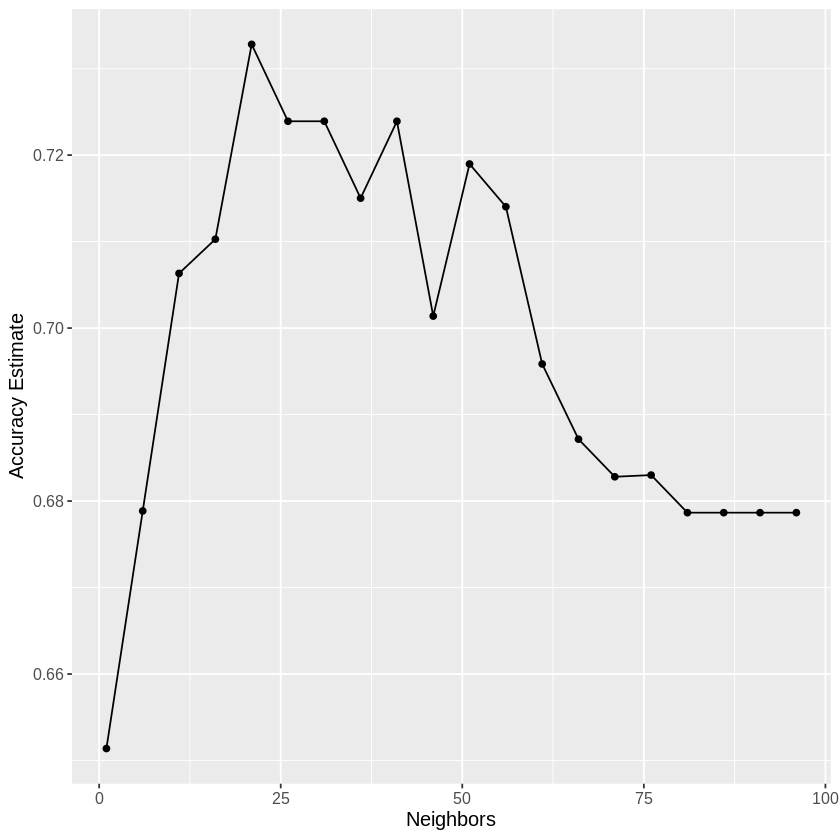

In [18]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12)) 

accuracy_vs_k

From the plot above, we can see that $K = 21$ provides the highest accuracy. $K$ values that are smaller or larger than this result in a reduced accuracy estimate.



## Building the classifier using the best K 

In [19]:
set.seed(2020) # DO NOT REMOVE

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
     set_engine("kknn") |>
     set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  fit(data = heart_data_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(21,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2633929
Best kernel: rectangular
Best k: 21

## Predicting new observations using the classifier

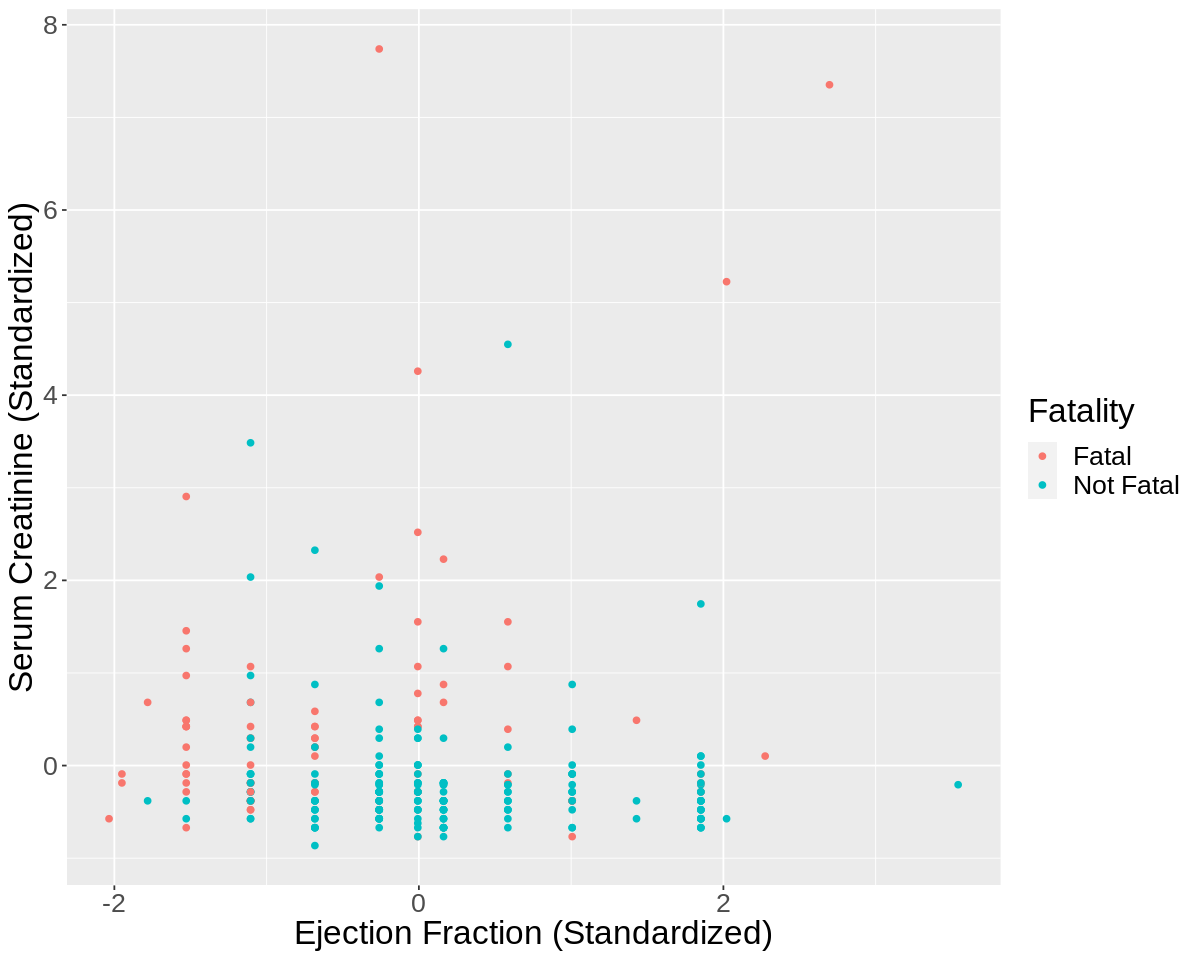

In [20]:
options(repr.plot.height = 8, repr.plot.width = 10)

plot_1 <- heart_subset |>
    ggplot(aes(x = scaled_ejection_fraction, y = scaled_serum_creatinine, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "Ejection Fraction (Standardized)", y = "Serum Creatinine (Standardized)", color = "Fatality")+
        theme(text = element_text(size = 20)) 

        
plot_1

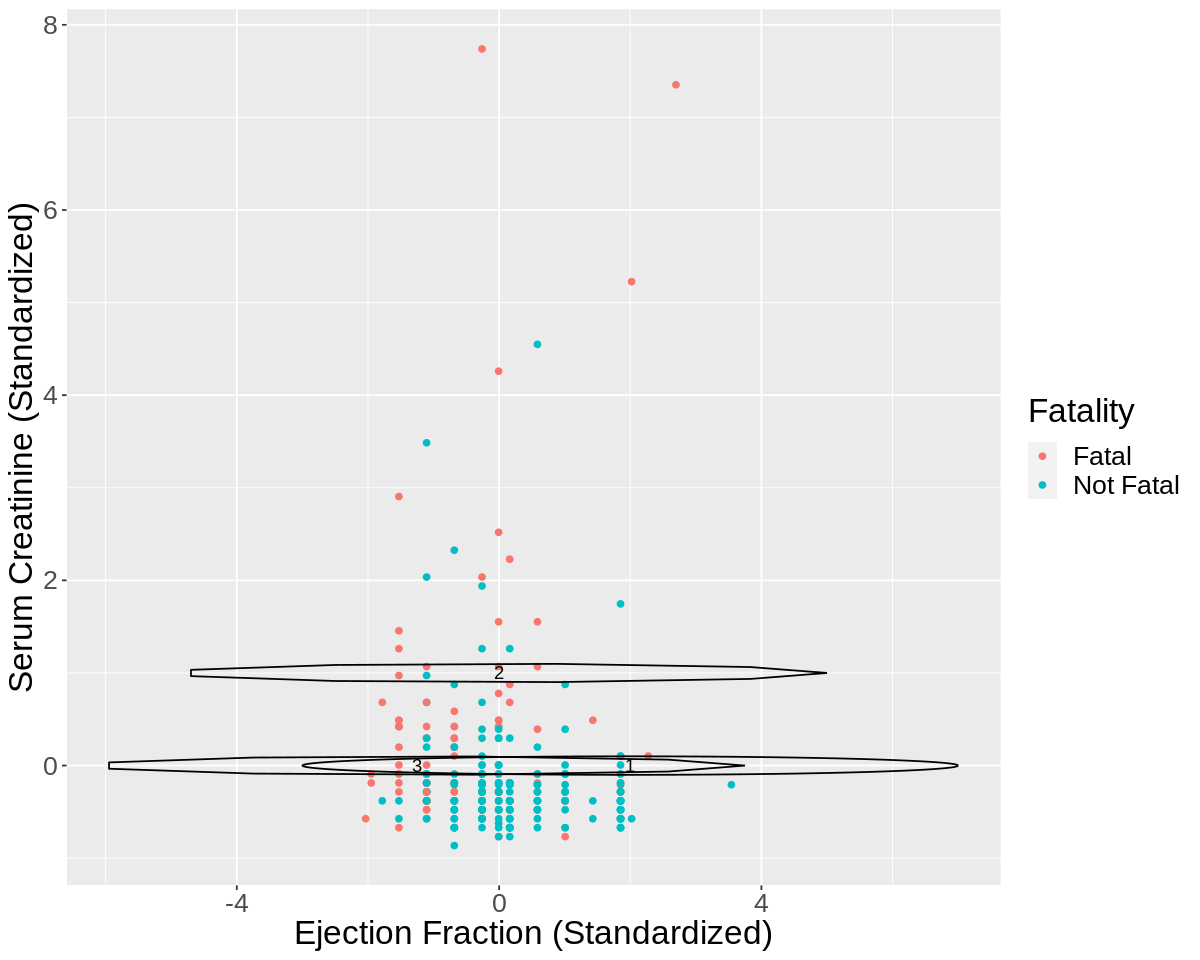

In [43]:
point1 <- c(2, 0)
point2 <- c(0, 1)
point3 <- c(-1.25, 0)

options(repr.plot.height = 8, repr.plot.width = 10)
plot_1 <- heart_subset |>
    ggplot(aes(x = scaled_ejection_fraction, y = scaled_serum_creatinine, col = as_factor(DEATH_EVENT))) +
        geom_point() +
        labs(x = "Ejection Fraction (Standardized)", y = "Serum Creatinine (Standardized)", color = "Fatality")+
        annotate("path", 
                 x=point1[1] + 5*cos(seq(0,2*pi,length.out=100)),
                 y=point1[2] + 0.1*sin(seq(0,2*pi,length.out=100))) +
        annotate("text", x = 2, y =  0, label = "1") +
        annotate("path",
                 x=point2[1] + 5*cos(seq(0,2*pi,length.out=10)),
                 y=point2[2] + 0.1*sin(seq(0,2*pi,length.out=10))) +
        annotate("text", x = 0, y =  1, label = "2") +
        annotate("path",
                 x=point3[1] + 5*cos(seq(0,2*pi,length.out=10)),
                 y=point3[2]+0.1*sin(seq(0,2*pi,length.out=10))) +
        annotate("text", x = -1.25, y =  0, label = "3") +
        theme(text = element_text(size = 20)) 

        
plot_1

Let's select an observation for predicting the fatality for it. 

Let the:
- ejection fraction be 2 
- serum creatinine be 0

In [27]:
observation_1 <- tibble(scaled_ejection_fraction = 2, scaled_serum_creatinine = 0)

Just by looking at the plot, we can say that fatality for (2,0) will be "Not fatal" because the points closer to it are mostly not fatal.

In [28]:
prediction <- predict(knn_fit, observation_1)

prediction

.pred_class
<fct>
Not Fatal


YAYY! It matches our prediction.

Let's try a new observation for predicting the fatality for it. 

Let the:
- ejection fraction be 0 
- serum creatinine be 2

In [29]:
observation_2 <- tibble(scaled_ejection_fraction = 0, scaled_serum_creatinine = 1)

Looking at the plot, we can say that fatality for (0,1) will be "Fatal" because the points closer to it are mostly fatal.

In [30]:
prediction <- predict(knn_fit, observation_2)

prediction

.pred_class
<fct>
Fatal


YAYY! It matches our prediction.

Let's try a new observation for predicting the fatality for it. 

Let the:
- ejection fraction be -1.25
- serum creatinine be 0

In [31]:
observation_3 <- tibble(scaled_ejection_fraction = -1.25, scaled_serum_creatinine = 0)

Looking at the plot, we can say that fatality for (0,1) will be "Fatal" because the points closer to it are mostly fatal.

In [26]:
prediction <- predict(knn_fit, observation_3)

prediction

.pred_class
<fct>
Fatal


YAYY! It matches our prediction.

## Methods

- We chose to remove all of the columns which had boolean observations and were not relevant except the death event which was the column to be predicted. We then scaled the data so that each column had equal contribution in the scatter plot.

- We used the scatter plot because it was the only visualization that would give us a logical relationship . The bar was very congested and the histogram didn’t show an accurate relationship. However, going forward, we might choose to further analyze the data and try using other forms of visualizations for the final project. 

## Expected outcomes and significance:

- **What do you expect to find?**
    
    We are expected to find if our model works well enough and is successful in predicting the relationship between different factors and how they
    affect death in the case of heart failure. For example, if a person with a high amount of ejection fraction is more or less likely to encounter 
    death upon undergoing heart failure. 
   
- **What impact could such findings have?**
    
    Finding the answer to such questions will allow us to control the variables which result in death in the case of heart failure, and minimize deaths
    which occur as a result of heart failure. This will have a huge impact as it can save numerous lives because heart failure is a leading cause of 
    death amongst adults.
    
- **What future questions could this lead to?**
    
    Some future questions which might potentially arise from this analysis are:
     
    1. How accurate is the analysis performed and how can the model be improved and refined in the future for results which are more 
          precise?
    2. Can such analysis and models be applied to different diseases across the medical field and help reduce the percentage of deaths 
          occuring overall? 